# Importing Libraries

In [38]:
import keras
import tensorflow
import numpy as np
import pandas as pd
from keras import layers, regularizers, Input, Model
from keras.models import Sequential
from keras.layers import Dense
from keras.saving.saving_api import load_model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard

## Variables

In [39]:
"""
-------------------------------------------Variables--------------------------------
"""
# -------- Pandas Dataframe
df = pd.read_csv("dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv")
# df.drop(columns = ['dport','sport'],inplace = True)
# columns
columns = df.columns.tolist()

# categorized columns`
nominal = [col for col in columns if df[col].dtype == 'object']
discrete = [col for col in columns if df[col].dtype == 'int64']
continuous = [col for col in columns if df[col].dtype == 'float']

# categorized dataframe
df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

#------------- enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# -------- Balanced subset
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced=pd.concat([df_class_1_subset, df_class_0])

C:\Users\faiza\AppData\Local\Temp\ipykernel_39156\2729474595.py:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv")


## Explore

In [40]:
print(df.info())
print(df_class_1.shape)
print(df_class_0.shape)
print(df_class_1_subset.shape)
print(df_balanced.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkSeqID                           668522 non-null  int64  
 1   stime                             668522 non-null  float64
 2   flgs                              668522 non-null  object 
 3   flgs_number                       668522 non-null  int64  
 4   proto                             668522 non-null  object 
 5   proto_number                      668522 non-null  int64  
 6   saddr                             668522 non-null  object 
 7   sport                             668522 non-null  object 
 8   daddr                             668522 non-null  object 
 9   dport                             668522 non-null  object 
 10  pkts                              668522 non-null  int64  
 11  bytes                             668522 non-null  i

In [41]:
for col in df:
    print(df[col].value_counts(), '\n')

pkSeqID
3000001    1
3445695    1
3445677    1
3445678    1
3445679    1
          ..
3222843    1
3222844    1
3222845    1
3222846    1
3668522    1
Name: count, Length: 668522, dtype: int64 

stime
1.528099e+09    29
1.528099e+09    28
1.528099e+09    28
1.528099e+09    27
1.528099e+09    27
                ..
1.526345e+09     1
1.526345e+09     1
1.526345e+09     1
1.526345e+09     1
1.529381e+09     1
Name: count, Length: 88102, dtype: int64 

flgs
e        654807
eU        11159
e s        2331
e d         113
e g          99
e &           5
e   t         4
e *           3
e  D          1
Name: count, dtype: int64 

flgs_number
1    654807
6     11159
2      2331
3       113
5        99
7         5
8         4
4         3
9         1
Name: count, dtype: int64 

proto
udp          592145
tcp           67202
icmp           9030
arp             137
ipv6-icmp         8
Name: count, dtype: int64 

proto_number
3    592145
1     67202
4      9030
2       137
5         8
Name: count, dt

## Transform Data

### Enumerate nominal columns

In [42]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n',  sep='\n')

before enumerating: flgs
flgs
e        654807
eU        11159
e s        2331
e d         113
e g          99
e &           5
e   t         4
e *           3
e  D          1
Name: count, dtype: int64


after enumerating: flgs
flgs
0    654807
8     11159
7      2331
5       113
6        99
3         5
1         4
4         3
2         1
Name: count, dtype: int64


before enumerating: proto
proto
udp          592145
tcp           67202
icmp           9030
arp             137
ipv6-icmp         8
Name: count, dtype: int64


after enumerating: proto
proto
4    592145
3     67202
1      9030
0       137
2         8
Name: count, dtype: int64


before enumerating: saddr
saddr
192.168.100.147              182905
192.168.100.148              167582
192.168.100.150              161085
192.168.100.149              147091
192.168.100.5                  5029
192.168.100.3                  4673
192.168.100.6                    38
192.168.100.7                    30
192.168.100.4                    1

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.drop(columns = ['attack'], inplace = True)
df = scaler.fit_transform(df)

### Baseline
latent space dimension = 22
1 hidden layer

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df,test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (534817, 45) (534817, 45)
Testing set shape: (133705, 45) (133705, 45)


In [45]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [46]:
# TODO: Set up the encoder to compute the reconstruction error
# This is the size of our encoded representations

encoding_dim = 30  # compression factor of ~2/3 per layer, assuming the input is 45 floats

# This is our input
Inputs = keras.Input(shape=(45,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(38, activation='relu')(Inputs)

encoded = layers.Dense(encoding_dim, activation='relu')(encoded)


decoded = layers.Dense(38, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(45, activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
SAE_model = keras.Model(Inputs, decoded)
SAE_model.compile(optimizer='RMSprop', loss='mse')

checkpointer = ModelCheckpoint(filepath="SAE_mode",
                               verbose=0,
                               save_best_only=True)

# Train the autoencoder
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [47]:
history = SAE_model.fit(X_train, X_train,
                        epochs=10,
                        batch_size=64,
                        shuffle= True,
                        validation_data=(X_val, X_val),
                        callbacks=[checkpointer, tensorboard]).history
autoencoder = load_model('SAE_mode')

Epoch 1/10
6676/6686 [============================>.] - ETA: 0s - loss: 0.0033

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 16s 2ms/step - loss: 0.0033 - val_loss: 7.5214e-04
Epoch 2/10
6678/6686 [============================>.] - ETA: 0s - loss: 5.9124e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 15s 2ms/step - loss: 5.9103e-04 - val_loss: 5.0131e-04
Epoch 3/10
6676/6686 [============================>.] - ETA: 0s - loss: 4.6664e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 15s 2ms/step - loss: 4.6670e-04 - val_loss: 4.5623e-04
Epoch 4/10
6670/6686 [============================>.] - ETA: 0s - loss: 4.1725e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 16s 2ms/step - loss: 4.1713e-04 - val_loss: 4.1365e-04
Epoch 5/10
6669/6686 [============================>.] - ETA: 0s - loss: 3.7720e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 17s 2ms/step - loss: 3.7702e-04 - val_loss: 3.7195e-04
Epoch 6/10
6678/6686 [============================>.] - ETA: 0s - loss: 3.4086e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 16s 2ms/step - loss: 3.4085e-04 - val_loss: 3.3255e-04
Epoch 7/10
6674/6686 [============================>.] - ETA: 0s - loss: 3.1437e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 16s 2ms/step - loss: 3.1432e-04 - val_loss: 2.9813e-04
Epoch 8/10
6686/6686 [==============================] - 15s 2ms/step - loss: 2.9528e-04 - val_loss: 3.0466e-04
Epoch 9/10
6669/6686 [============================>.] - ETA: 0s - loss: 2.8185e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 15s 2ms/step - loss: 2.8185e-04 - val_loss: 2.8278e-04
Epoch 10/10
6669/6686 [============================>.] - ETA: 0s - loss: 2.7121e-04

INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 15s 2ms/step - loss: 2.7109e-04 - val_loss: 2.7815e-04


In [48]:
x_hat = SAE_model.predict(X_test)
mse = np.mean(np.power(X_test - x_hat, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
error_df

4179/4179 [==============================] - 5s 1ms/step


,Reconstruction_error
0,0.000099
1,0.000096
2,0.000077
3,0.000063
4,0.000184
...,...
133700,0.000159
133701,0.000523
133702,0.000150
133703,0.000108


In [49]:
average_reconstruction_error = sum(mse)/len(mse)
average_reconstruction_error

0.00027438616834789584

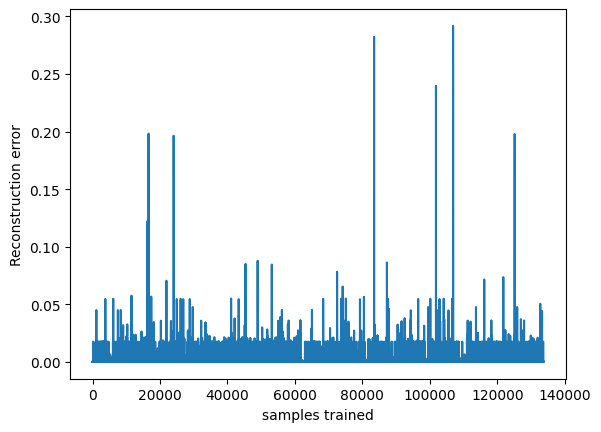

In [65]:
plt.plot(error_df.Reconstruction_error)
plt.xlabel('samples trained')
plt.ylabel('Reconstruction error')
plt.show()

In [63]:
mse_df = pd.DataFrame(mse)
mse_df.describe()

,0
count,133705.000000
mean,0.000274
std,0.002353
min,0.000017
25%,0.000070
50%,0.000102
75%,0.000160
max,0.291663


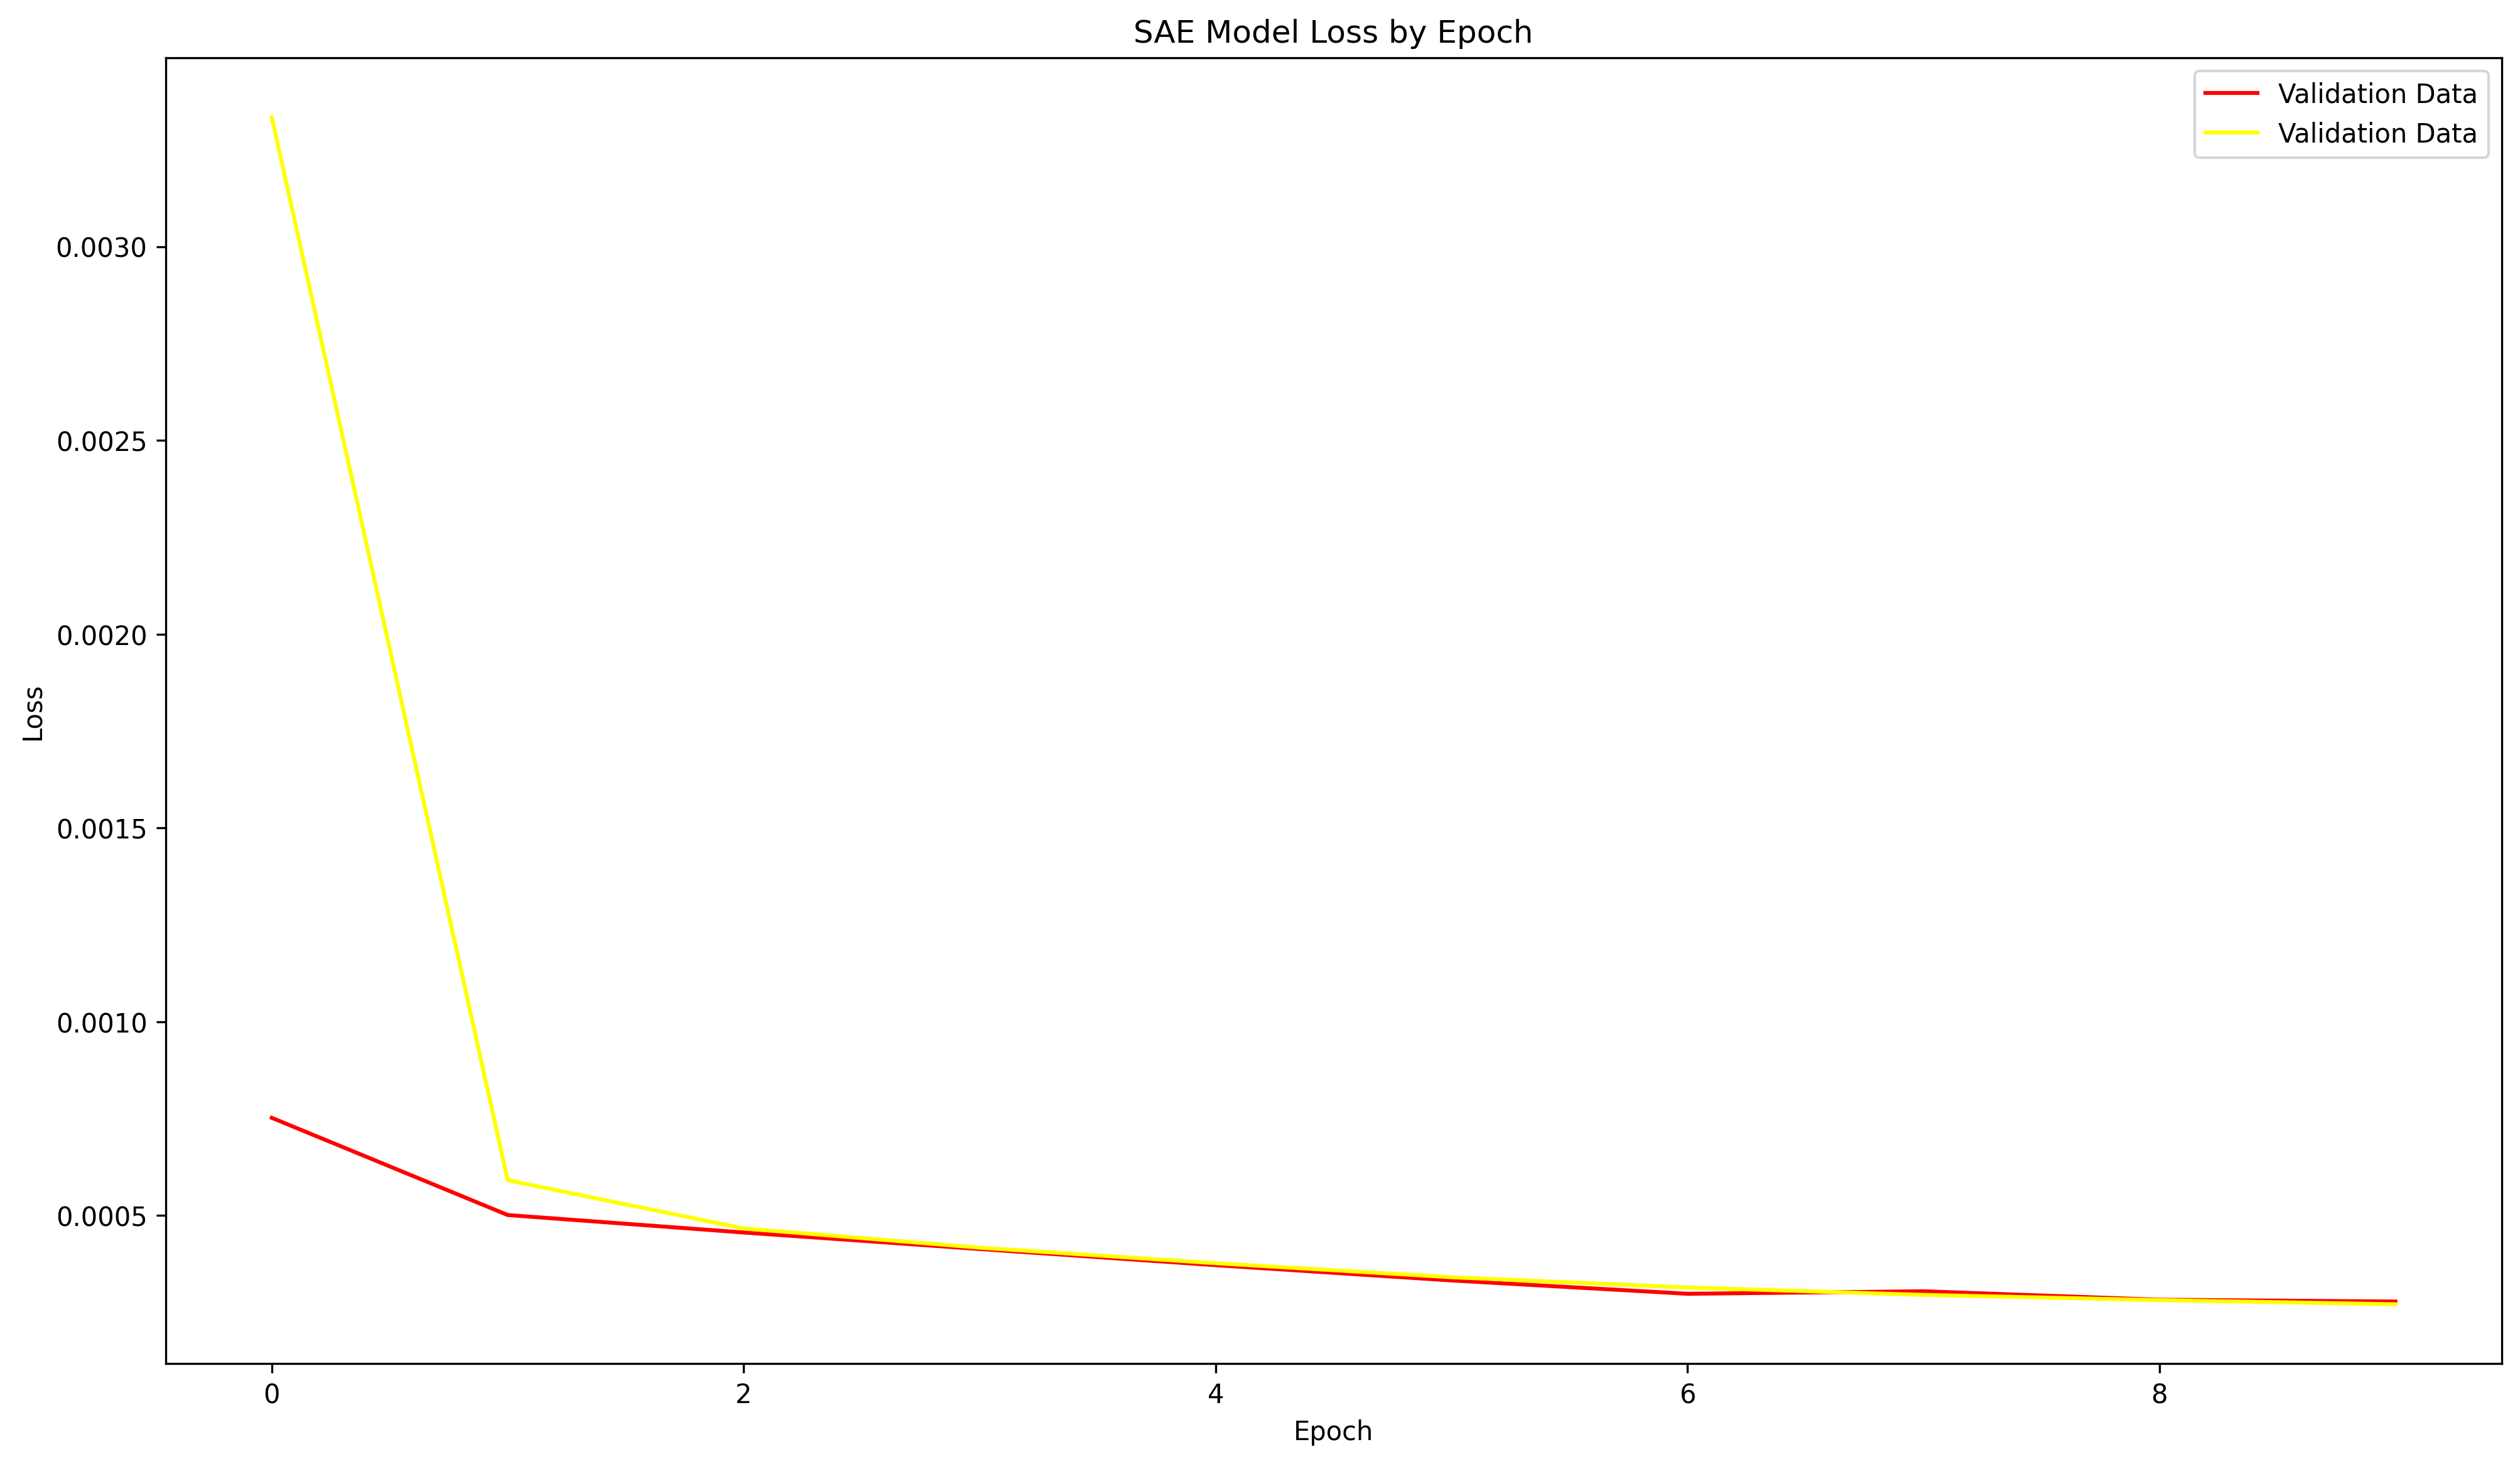

In [56]:
Sfig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(history['val_loss'], label='Validation Data', color='red')
ax.plot(history['loss'], label='Validation Data', color='yellow')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()

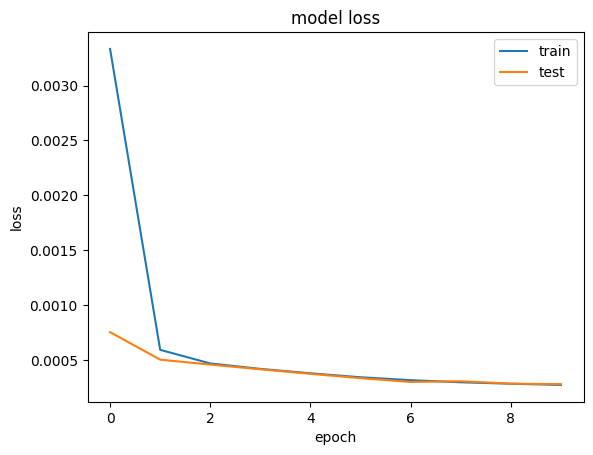

In [64]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');